### CIFAR 10 

In [3]:
import os
import pickle
import numpy as np

In [5]:
# loading the Dataset

In [7]:
# we create a function to load our batches and turn them from pickled to arrays so we can work with them
def load_batch(file_path):
    with open(file_path, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
        images = batch[b'data']
        labels = batch[b'labels']
        return images, labels

In [9]:
# we create empty lists to store all the batches
all_images = []
all_labels = []

In [11]:
base_path = r"C:\Users\30697\KAGGLE\CIFAR10\archive (5)" # we use the base so we can call them all 

In [13]:
for i in range(1, 6):
    file_path = os.path.join(base_path, f"data_batch_{i}")
    images, labels = load_batch(file_path)
    all_images.append(images)
    all_labels.append(labels)

In [15]:
# Combine all training batches
X_train = np.concatenate(all_images, axis=0)  # (50000, 3072)
y_train = np.concatenate(all_labels, axis=0)  # (50000,)

In [18]:
# Load test batch
X_test, y_test = load_batch(os.path.join(base_path, "test_batch"))

In [20]:
y_test = np.array(y_test) #it uploaded as a list

In [22]:
y_test.shape

(10000,)

In [24]:
print("Training set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)

Training set: (50000, 3072) (50000,)
Test set: (10000, 3072) (10000,)


In [26]:
# Our Data are flattende and we must reshaoe them to 3D images to "feed" them to a CNN model.
#I dont reshape y because the output of the CNN is flatten as well
X_train = X_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
X_test  = X_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  

In [28]:
print(X_train.shape, X_test.shape)# 32x32x 3=rgb

(50000, 32, 32, 3) (10000, 32, 32, 3)


In [30]:
# Normalize pixel values around zero
X_train = X_train / 127.5 - 1
X_test  = X_test / 127.5 - 1

In [35]:
#MODELING -
# I ll train a CNN and see the results

In [68]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [56]:
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [60]:
X_train_split.shape

(45000, 32, 32, 3)

In [64]:
from functools import partial

In [80]:
Cond2Def=partial(tf.keras.layers.Conv2D,kernel_size=3,padding="same",activation="relu",kernel_initializer="he_normal")

In [86]:
model=tf.keras.Sequential([
    Cond2Def(filters=64,kernel_size=7,input_shape=[32,32,3]),
    MaxPooling2D((2,2)),
    Cond2Def(filters=128),
    Cond2Def(filters=128),
    MaxPooling2D((2,2)),
    Cond2Def(filters=256),
    Cond2Def(filters=256),
    MaxPooling2D((2,2)), 
             
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128,activation="relu",kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64,activation="relu",kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10,activation="softmax")
             ])



In [88]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [185]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        9472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 256)         2

In [90]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
restore_best_weights=True)

In [92]:
model.fit(X_train_split, y_train_split,validation_data=(X_val,y_val), epochs=30,callbacks=([early_stopping_cb]),batch_size=32)

Epoch 1/30
1407/1407 [==============================] - 176s 123ms/step - loss: 1.8985 - accuracy: 0.2845 - val_loss: 1.5583 - val_accuracy: 0.4186
Epoch 2/30
1407/1407 [==============================] - 163s 116ms/step - loss: 1.5035 - accuracy: 0.4476 - val_loss: 1.2783 - val_accuracy: 0.5326
Epoch 3/30
1407/1407 [==============================] - 174s 124ms/step - loss: 1.3329 - accuracy: 0.5252 - val_loss: 1.1657 - val_accuracy: 0.5884
Epoch 4/30
1407/1407 [==============================] - 167s 119ms/step - loss: 1.2222 - accuracy: 0.5746 - val_loss: 1.0462 - val_accuracy: 0.6316
Epoch 5/30
1407/1407 [==============================] - 167s 118ms/step - loss: 1.1141 - accuracy: 0.6172 - val_loss: 1.0013 - val_accuracy: 0.6582
Epoch 6/30
1407/1407 [==============================] - 167s 119ms/step - loss: 1.0354 - accuracy: 0.6464 - val_loss: 0.9810 - val_accuracy: 0.6584
Epoch 7/30
1407/1407 [==============================] - 193s 137ms/step - loss: 0.9751 - accuracy: 0.6723 - val_

In [94]:
### The model achives high training accuracy but significantly lower validation accuracy wjich indicates overfitting and poor 
### generalization.This suggests that the model is learning training-specific patterns rather than robust feauters that transfer to unseen data.

### To improve generalization we can try smaller input kernel( 7x7 way too big for 32x32) , reducing parameters(remove 1 Dense layer) 
### and we will introduce data augmentation.

In [96]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [98]:
ImageGen = ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=15,
    zoom_range=0.1
)

In [100]:
model2=tf.keras.Sequential([
    Cond2Def(filters=64,input_shape=[32,32,3]),
    MaxPooling2D((2,2)),
    Cond2Def(filters=128),
    Cond2Def(filters=128),
    MaxPooling2D((2,2)),
    Cond2Def(filters=256),
    Cond2Def(filters=256),
    MaxPooling2D((2,2)), 
             
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units=128,activation="relu",kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10,activation="softmax")
             ])


In [102]:
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [183]:
model2.summary()
# from 1.600.000 parameters down to 1.100.000

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 256)        

In [106]:
history2 = model2.fit(
    ImageGen.flow(X_train_split, y_train_split, batch_size=32),
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_cb]
)

Epoch 1/30
1407/1407 [==============================] - 166s 117ms/step - loss: 1.7193 - accuracy: 0.3606 - val_loss: 1.2973 - val_accuracy: 0.5144
Epoch 2/30
1407/1407 [==============================] - 179s 127ms/step - loss: 1.3072 - accuracy: 0.5330 - val_loss: 1.3385 - val_accuracy: 0.5340
Epoch 3/30
1407/1407 [==============================] - 166s 118ms/step - loss: 1.1037 - accuracy: 0.6138 - val_loss: 1.1230 - val_accuracy: 0.6104
Epoch 4/30
1407/1407 [==============================] - 165s 117ms/step - loss: 0.9803 - accuracy: 0.6608 - val_loss: 0.7980 - val_accuracy: 0.7226
Epoch 5/30
1407/1407 [==============================] - 163s 116ms/step - loss: 0.8874 - accuracy: 0.6991 - val_loss: 0.8108 - val_accuracy: 0.7168
Epoch 6/30
1407/1407 [==============================] - 168s 119ms/step - loss: 0.8201 - accuracy: 0.7231 - val_loss: 0.8000 - val_accuracy: 0.7378
Epoch 7/30
1407/1407 [==============================] - 169s 120ms/step - loss: 0.7627 - accuracy: 0.7433 - val_

In [108]:
test_loss, test_acc = model2.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}")

313/313 - 9s - loss: 0.5450 - accuracy: 0.8200 - 9s/epoch - 27ms/step
Test Accuracy: 0.8200


In [127]:
import matplotlib.pyplot as plt
import pandas as pd

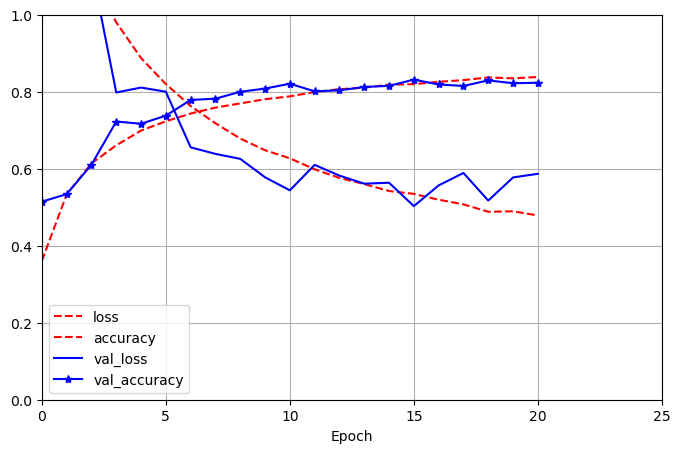

In [133]:
pd.DataFrame(history2.history).plot(
    figsize=(8,5),xlim=[0,25],ylim=[0,1],grid=True,xlabel="Epoch",
    style=["r--","r--","b-","b-*"])
plt.show()

In [137]:
### The final model achieved 83.8% training accuracy and 82.3% validation accuracy, with a minimal generalization gap. This indicates that
### regularization techniques such as data augmentation, Global Average Pooling, and EarlyStopping were effective in reducing overfitting 
### and improving robustness on unseen data.

In [141]:
y_pred_probs = model2.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

313/313 [==============================] - 17s 50ms/step


In [143]:
from sklearn.metrics import confusion_matrix

In [170]:
class_names = [
    "airplane","automobile","bird","cat","deer",
    "dog","frog","horse","ship","truck"
]

In [161]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[846,  10,  33,  23,   7,   1,   2,   8,  27,  43],
       [  8, 903,   0,   3,   0,   1,   1,   0,   5,  79],
       [ 48,   3, 709,  54,  34,  39,  69,  22,   4,  18],
       [ 11,   4,  41, 690,  40,  94,  61,  33,  10,  16],
       [ 11,   2,  29,  46, 754,  19,  59,  68,   3,   9],
       [  4,   2,  18, 175,  28, 703,  28,  32,   1,   9],
       [  7,   1,  17,  42,   9,   9, 904,   2,   2,   7],
       [ 10,   0,   6,  42,  19,  20,  11, 881,   0,  11],
       [ 43,  17,   7,  17,   1,   1,   4,   6, 874,  30],
       [ 15,  26,   3,   8,   0,   1,   0,   3,   8, 936]], dtype=int64)

In [164]:
from sklearn.metrics import classification_report

In [166]:
print(classification_report(
    y_test,
    y_pred,
    target_names=[
        "airplane","automobile","bird","cat","deer",
        "dog","frog","horse","ship","truck"
    ]
))

              precision    recall  f1-score   support

    airplane       0.84      0.85      0.84      1000
  automobile       0.93      0.90      0.92      1000
        bird       0.82      0.71      0.76      1000
         cat       0.63      0.69      0.66      1000
        deer       0.85      0.75      0.80      1000
         dog       0.79      0.70      0.74      1000
        frog       0.79      0.90      0.85      1000
       horse       0.84      0.88      0.86      1000
        ship       0.94      0.87      0.90      1000
       truck       0.81      0.94      0.87      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



In [172]:
misclassified_idx = np.where(
    ((y_test == 3) & (y_pred == 5)) |  # cat → dog
    ((y_test == 5) & (y_pred == 3))    # dog → cat
)[0]

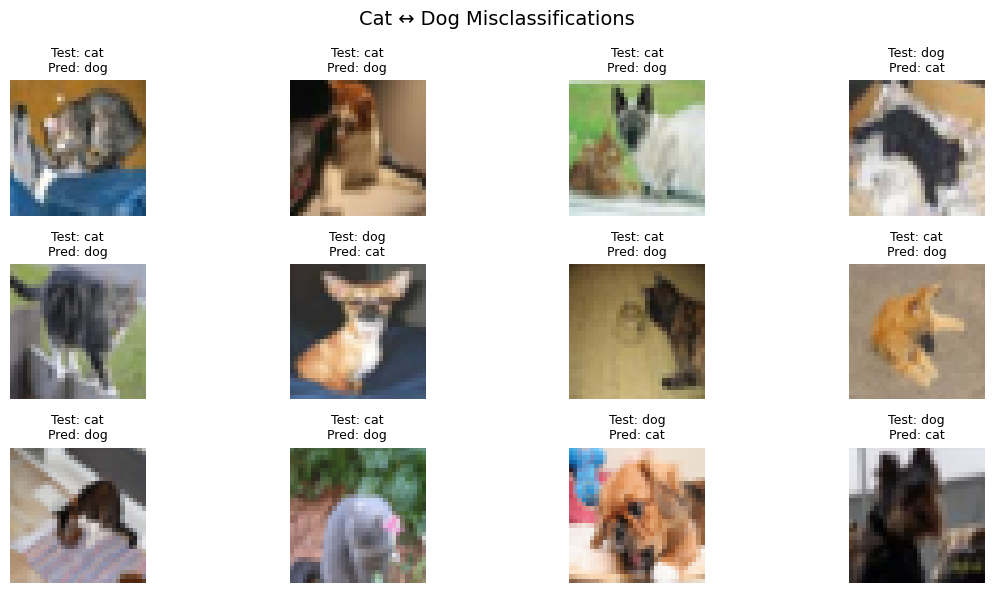

In [178]:
num_images = 12
plt.figure(figsize=(12,6))

for i, idx in enumerate(misclassified_idx[:num_images]):
    plt.subplot(3, 4, i + 1)    
    # convert back
    img = (X_test[idx] + 1) / 2
    plt.imshow(img)
    plt.axis("off")
    
    plt.title(
        f"Test: {class_names[y_test[idx]]}\n"
        f"Pred: {class_names[y_pred[idx]]}",
        fontsize=9
    )

plt.suptitle("Cat - Dog Misclassifications", fontsize=14)
plt.tight_layout()
plt.show()

In [187]:
# This model achieves high training accuracy with a minimal gap to validation  accuracy, indicating good generalization. 
# Architectural decisions such as stacked 3×3 convolutions, Global Average Pooling instead of Flatten, data
# augmentation, and EarlyStopping were used to reduce overfitting and improve  robustness on unseen data.
# Evaluation on the test set confirms stable performance across most CIFAR-10 classes, with remaining errors primarily
# between visually similar categories (e.g., cats vs dogs).